<a href="https://colab.research.google.com/github/hp241t/Automobile_Data_Analysis/blob/master/Time_Series_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tf-nightly-2.0-preview

     |████████████████████████████████| 95.2MB 29kB/s 
     |████████████████████████████████| 3.8MB 35.0MB/s 
     |████████████████████████████████| 450kB 42.0MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
ERROR: tb-nightly 2.1.0a20191201 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [0]:
def plot_series(time, series, format="-", start = 0, end = None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid('True')

# Trend and Seasonality

In [0]:
def trend(time, slope=0):
  return slope * time

Lets create a time series that just trends upward:

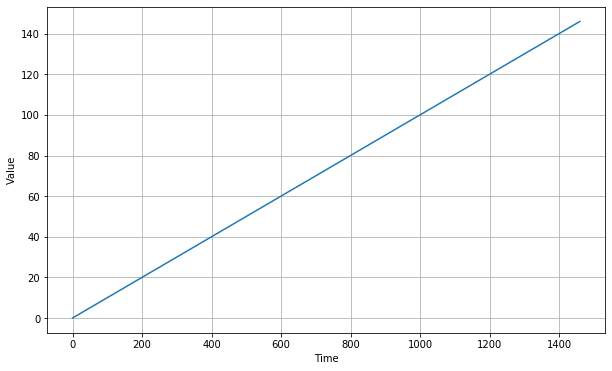

In [8]:
time = np.arange(4*365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

### Lets generate time series with seasonality pattern

In [0]:
def seasonal_pattern(season_time):
  return np.where(season_time<0.4, 
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3* season_time))
  
def seasonality(time, period=365, amplitude=1, phase=0):
  season_time = ((time+phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

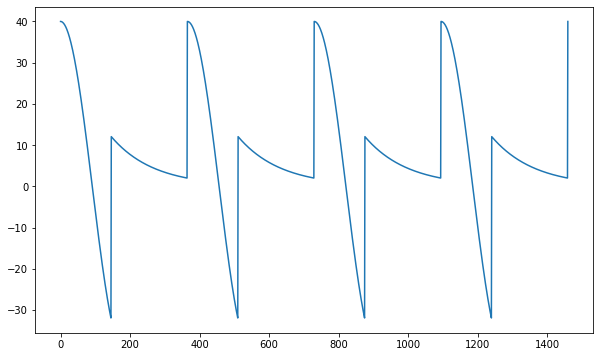

In [11]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10,6))
plt.plot(time, series )
plt.show()

### Lets create a time series for both trend and seasonality

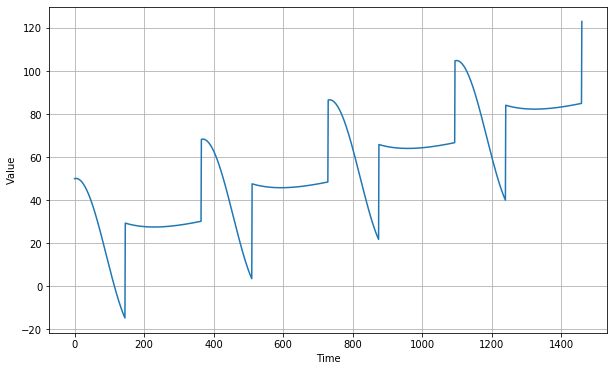

In [13]:
slope =0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()
                                          
                                                    

## *Noise*


In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [0]:
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

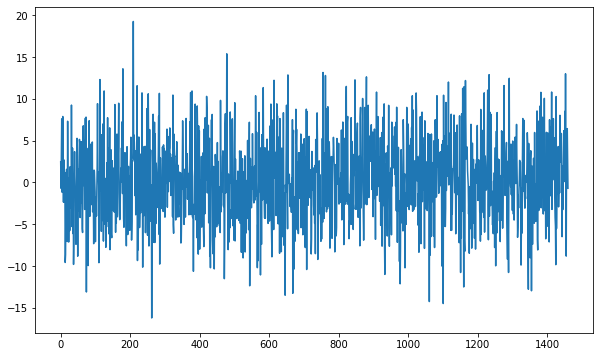

In [19]:
noise_level = 5
noise = white_noise(time, noise_level, seed =42)

plt.figure(figsize=(10,6))
plt.plot(time, noise)
plt.show()

Now let's add this white noise to the time series:

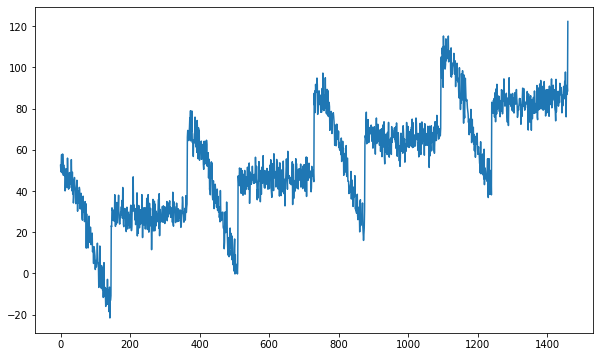

In [20]:
series += noise

plt.figure(figsize=(10,6))
plt.plot(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]



In [0]:
def autocorrelation(time, amplitude, seed=None):
  